In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
def get_im(path):
    im = cv2.imread(path)
    return im

def display_bgr(im):
    plt.imshow(im[:,:,[2,1,0]])
    plt.show()
    
def make_even_shape(im):
    if im.shape[0] % 2 != 0 and im.shape[1] != 0:
        return im[:im.shape[0]-1, :im.shape[1]-1]
    
    elif im.shape[0] % 2 != 0:
        return im[:im.shape[0]-1, :]
    
    elif im.shape[1] % 2 != 0:
        return im[:, im.shape[1]-1]
    
    else:
        return im

In [9]:
"""
Calculates the mean squared difference per pixel between two images on [0,255] scale.
"""
def mse(im1, im2):
    # Ensure proper format
    if type(im1[0,0,0]) == np.uint8:
        im1 = im1.astype(float) * 255
        
    if type(im2[0,0,0]) == np.uint8:
        im2 = im2.astype(float) * 255
        
    return np.mean((im1 - im2) ** 2)

"""
Calculate the mean absolute difference per pixel between two images on [0, 255] scale.
"""
def mae(im1, im2):
    # Ensure proper format
    if type(im1[0,0,0]) == np.uint8:
        im1 = im1.astype(float) * 255
        
    if type(im2[0,0,0]) == np.uint8:
        im2 = im2.astype(float) * 255
        
    return np.mean(np.abs(im1 - im2))
    

In [14]:
"""
Downsamples an image by factor of 2 by throwing out every odd indexed pixel.
Assumes even image shape

"""
def downsample(im):
    shape = im.shape
    new_shape = (shape[0] // 2, shape[1] // 2, shape[2])

    new_im = np.zeros(new_shape, dtype=np.uint8)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if j % 2 == 0 and i % 2 == 0:
                new_im[i//2, j//2] = im[i, j]
                    
    return new_im

def cv2_downsample(im):
    # https://www.tutorialkart.com/opencv/python/opencv-python-resize-image/#gsc.tab=0
    scale_percent = 50 # percent of original size
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
  
    # resize image
    resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    
    return resized

"""
Prepares to upsample and image by factor of 2 by creating an image where every even indexed pixel originates from
the provided image and every odd indexed pixel is empty.
"""
def prep_upsample(im):
    new_shape = (im.shape[0] * 2, im.shape[1] * 2, im.shape[2])
    new_im = np.zeros(new_shape, dtype=np.uint8)
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            new_im[i*2, j*2] = im[i, j]
                            
    return new_im

In [11]:
"""
Given a prepped image, fills in the "empty" pixels (odd indices) by averaging all even indexed pixels up to k steps away.
This implementation only works for images prepped by prep_upsample
"""
def KNN_upsample(im, k=1):
    new_im = np.ones_like(im)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if i % 2 == 1 or j % 2 == 1:
                # Must fill this value by performing a KNN average
                neighbor_pixel_values = []
                for m in range(max(0, i-k), min(i+k+1, im.shape[0]-1)):
                    for n in range(max(0, j-k), min(j+k+1, im.shape[1]-1)):
                        if m % 2 == 0 and n % 2 == 0:
                            neighbor_pixel_values.append(im[m, n])
                            
                to_average = np.array(neighbor_pixel_values)
                avg_value = np.mean(to_average, axis=0)
                new_im[i, j] = avg_value
            else:
                new_im[i, j] = im[i, j]
                
    
    return new_im

Im shape (300, 400, 3)
Even im shape (300, 400, 3)


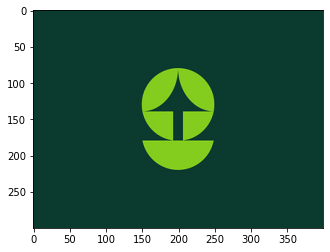

New im shape (150, 200, 3)


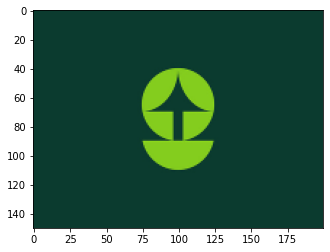

Prepped shape (300, 400, 3)


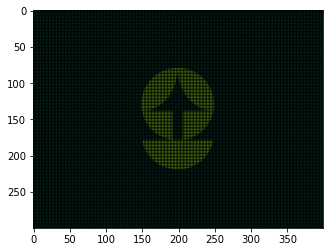

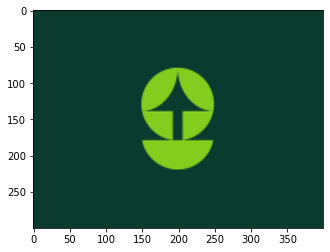

MSE 1483149.625625
MAE 153.265625


In [17]:
im = get_im("no_black_logo.jpg")
print("Im shape", im.shape)
im = make_even_shape(im)
print("Even im shape", im.shape)
display_bgr(im)

smaller_im = cv2_downsample(im)
print("New im shape", smaller_im.shape)
display_bgr(smaller_im)

prepped_im = prep_upsample(smaller_im)
print("Prepped shape", prepped_im.shape)
display_bgr(prepped_im)

upsampled_im = KNN_upsample(prepped_im, k=1)
display_bgr(upsampled_im)

print("MSE", mse(im, upsampled_im))
print("MAE", mae(im, upsampled_im))